# Construction

In this section, we construct two classes to implement a basic feed-forward neural network. For simplicity, both are limited to one hidden layer, though the number of neurons in the input, hidden, and output layers is flexible. The two differ in how they combine results across observations. The first loops through observations and adds the individual gradients while the second calculates the entire gradient across observatinos in one fell swoop. 

Let's start by importing `numpy`, some visualization packages, and two datasets: the {doc}`Boston </content/appendix/data>` housing and {doc}`breast cancer </content/appendix/data>` datasets from `scikit-learn`. We will use the former for regression and the latter for classification. We also split each dataset into a train and test set. This is done with the hidden code cell below

In [591]:
## Import numpy and visualization packages
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

## Import Boston and standardize
np.random.seed(123)
boston = datasets.load_boston()
X_boston = boston['data']
X_boston = (X_boston - X_boston.mean(0))/(X_boston.std(0))
y_boston = boston['target']

## Train-test split
np.random.seed(123)
test_frac = 0.25
test_size = int(len(y_boston)*test_frac)
test_idxs = np.random.choice(np.arange(len(y_boston)), test_size, replace = False)
X_boston_train = np.delete(X_boston, test_idxs, 0)
y_boston_train = np.delete(y_boston, test_idxs, 0)
X_boston_test = X_boston[test_idxs]
y_boston_test = y_boston[test_idxs]

## Import cancer and standardize
np.random.seed(123)
cancer = datasets.load_breast_cancer()
X_cancer = cancer['data']
X_cancer = (X_cancer - X_cancer.mean(0))/(X_cancer.std(0))
y_cancer = 1*(cancer['target'] == 1)

## Train-test split
np.random.seed(123)
test_frac = 0.25
test_size = int(len(y_cancer)*test_frac)
test_idxs = np.random.choice(np.arange(len(y_cancer)), test_size, replace = False)
X_cancer_train = np.delete(X_cancer, test_idxs, 0)
y_cancer_train = np.delete(y_cancer, test_idxs, 0)
X_cancer_test = X_cancer[test_idxs]
y_cancer_test = y_cancer[test_idxs]

Before constructing classes for our network, let's build our activation functions. Below we implement the ReLU function, sigmoid function, and the linear function (which simply returns its input). Let's also combine these functions into a dictionary so we can identify them with a string argument. 

In [544]:
## Activation Functions 
def ReLU(h):
    return np.maximum(h, 0)

def sigmoid(h):
    return 1/(1 + np.exp(-h))
    
def linear(h):
    return h

activation_function_dict = {'ReLU':ReLU, 'sigmoid':sigmoid, 'linear':linear}

## 1. The Loop Approach

Next, we construct a class for fitting feed-forward networks by looping through observations. This class conducts gradient descent by calculating the gradients based on one observation at a time, looping through all observations, and summing the gradients before adjusting the weights.

Once instantiated, we fit a network with the `fit()` method. This method requires training data, the number of nodes for the hidden layer, an activation function for the first and second layers' outputs, a loss function, and some parameters for gradient descent. After storing those values, the method randomly instantiates the network's weights: `W1`, `c1`, `W2`, and `c2`. It then passes the data through this network to instantiate the output values: `h1`, `z1`, `h2`, and `yhat` (equivalent to `z2`).

We then begin conducting gradient descent. Within each iteration of the gradient descent process, we also iterate through the observations. For each observation, we calculate the derivative of the loss for that observation with respect to the network's weights. We then sum these individual derivatives and adjust the weights accordingly, as is typical in gradient descent. The derivatives we calculate are covered in the {doc}`concept section </content/c7/concept>`. 

Once the network is fit, we can form predictions with the `predict()` method. This simply consists of running test observations through the network and returning their outputs.


In [607]:
class FeedForwardNeuralNetwork:
    
    def fit(self, X, y, n_hidden, f1 = 'ReLU', f2 = 'linear', loss = 'RSS', lr = 1e-5, n_iter = 1e3, seed = None):
        
        ## Store Information
        self.X = X
        self.y = y.reshape(len(y), -1)
        self.N = len(X)
        self.D_X = self.X.shape[1]
        self.D_y = self.y.shape[1]
        self.D_h = n_hidden
        self.f1, self.f2 = f1, f2
        self.loss = loss
        self.lr = lr
        self.n_iter = int(n_iter)
        self.seed = seed
        
        ## Instantiate Weights
        np.random.seed(self.seed)
        self.W1 = np.random.randn(self.D_h, self.D_X)/5
        self.c1 = np.random.randn(self.D_h, 1)/5
        self.W2 = np.random.randn(self.D_y, self.D_h)/5
        self.c2 = np.random.randn(self.D_y, 1)/5
        
        ## Instantiate Outputs
        self.h1 = np.dot(self.W1, self.X.T) + self.c1
        self.z1 = activation_function_dict[f1](self.h1)
        self.h2 = np.dot(self.W2, self.z1) + self.c2
        self.yhat = activation_function_dict[f2](self.h2)
        
        ## Fit Weights
        for iteration in range(self.n_iter):
            
            dL_dW2 = 0
            dL_dc2 = 0
            dL_dW1 = 0
            dL_dc1 = 0
            
            for n in range(self.N):
                
                # dL_dyhat
                if loss == 'RSS':
                    dL_dyhat = -2*(self.y[n] - self.yhat[:,n]).T # (1, D_y)
                elif loss == 'log':
                    dL_dyhat = (-(self.y[n]/self.yhat[:,n]) + (1-self.y[n])/(1-self.yhat[:,n])).T # (1, D_y)
                
        
                ## LAYER 2 ## 
                # dyhat_dh2 
                if f2 == 'linear':
                    dyhat_dh2 = np.eye(self.D_y) # (D_y, D_y)
                elif f2 == 'sigmoid':
                    dyhat_dh2 = np.diag(sigmoid(self.h2[:,n])*(1-sigmoid(self.h2[:,n]))) # (D_y, D_y)
                    
                # dh2_dc2
                dh2_dc2 = np.eye(self.D_y) # (D_y, D_y)
                
                # dh2_dW2 
                dh2_dW2 = np.zeros((self.D_y, self.D_y, self.D_h)) # (D_y, (D_y, D_h)) 
                for i in range(self.D_y):
                    dh2_dW2[i] = self.z1[:,n] 
                
                # dh2_dz1
                dh2_dz1 = self.W2 # (D_y, D_h)
                
                
                ## LAYER 1 ##
                # dz1_dh1
                if f1 == 'ReLU':
                    dz1_dh1 = 1*np.diag(self.h1[:,n] > 0) # (D_h, D_h)                
                elif f1 == 'linear':
                    dz1_dh1 = np.eye(self.D_h) # (D_h, D_h)

                
                # dh1_dc1 
                dh1_dc1 = np.eye(self.D_h) # (D_h, D_h)
                
                # dh1_dW1
                dh1_dW1 = np.zeros((self.D_h, self.D_h, self.D_X)) # (D_h, (D_h, D_X))
                for i in range(self.D_h):
                    dh1_dW1[i] = self.X[n]
                
                
                ## DERIVATIVES W.R.T. LOSS ## 
                dL_dh2 = dL_dyhat @ dyhat_dh2
                dL_dW2 += dL_dh2 @ dh2_dW2
                dL_dc2 += dL_dh2 @ dh2_dc2
                dL_dh1 = dL_dh2 @ dh2_dz1 @ dz1_dh1
                dL_dW1 += dL_dh1 @ dh1_dW1
                dL_dc1 += dL_dh1 @ dh1_dc1
            
            ## Update Weights
            self.W1 -= self.lr * dL_dW1
            self.c1 -= self.lr * dL_dc1.reshape(-1, 1)           
            self.W2 -= self.lr * dL_dW2            
            self.c2 -= self.lr * dL_dc2.reshape(-1, 1)                    
            
            ## Update Outputs
            self.h1 = np.dot(self.W1, self.X.T) + self.c1
            self.z1 = activation_function_dict[f1](self.h1)
            self.h2 = np.dot(self.W2, self.z1) + self.c2
            self.yhat = activation_function_dict[f2](self.h2)
            
    def predict(self, X_test):
        self.h1 = np.dot(self.W1, X_test.T) + self.c1
        self.z1 = activation_function_dict[self.f1](self.h1)
        self.h2 = np.dot(self.W2, self.z1) + self.c2
        self.yhat = activation_function_dict[self.f2](self.h2)        
        return self.yhat
    

Let's try building a network with this class using the `boston` housing data. This network contains 8 neurons in its hidden layer and uses the ReLU and linear activation functions after the first and second layers, respectively.

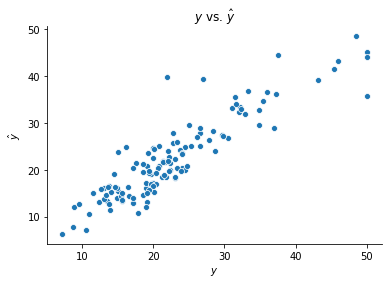

In [625]:
ffnn = FeedForwardNeuralNetwork()
ffnn.fit(X_boston_train, y_boston_train, n_hidden = 8)
y_boston_test_hat = ffnn.predict(X_boston_test)

fig, ax = plt.subplots()
sns.scatterplot(y_boston_test, y_boston_test_hat[0])
ax.set(xlabel = r'$y$', ylabel = r'$\hat{y}$', title = r'$y$ vs. $\hat{y}$')
sns.despine()

We can also build a network for binary classification. The model below attempts to predict whether an individual's cancer is malignant or benign. We use the log loss, the sigmoid activation function after the second layer, and the ReLU function after the first.

In [617]:
ffnn = FeedForwardNeuralNetwork()
ffnn.fit(X_cancer_train, y_cancer_train, n_hidden = 8,
         loss = 'log', f2 = 'sigmoid', seed = 123, lr = 1e-4)
y_cancer_test_hat = ffnn.predict(X_cancer_test)
np.mean(y_cancer_test_hat.round() == y_cancer_test)


0.9929577464788732

## 2. The Matrix Approach

Below is a second class for fitting neural networks that runs *much* faster by simultaneously calculating the gradients across observations. The math behind these calculations is outlined in the {doc}`concept section </content/c7/concept>`. This class's fitting algorithm is identical to that of the one above with one big exception: we don't have to iterate over observations.

Most of the following gradient calculations are straightforward. A few require a tensor dot product, which is easily done using numpy. Consider the following gradient:

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}^{(L)}_{i, j}} = \sum_{n = 1}^N (\nabla \mathbf{H}^{(L)})_{i, n}\cdot \mathbf{Z}^{(L-1)}_{j, n}.
$$

In words, $\partial\mathcal{L}/\partial \mathbf{W}^{(L)}$ is a matrix whose $(i, j)^\text{th}$ entry equals the sum across the $i^\text{th}$ row of $\nabla \mathbf{H}^{(L)}$ multiplied element-wise with the $j^\text{th}$ row of $\mathbf{Z}^{(L-1)}$. 

This calculation can be accomplished with `np.tensordot(A, B, (1,1))`, where `A` is $\nabla \mathbf{H}^{(L)}$ and `B` is $\mathbf{Z}^{(L-1)}$. `np.tensordot()` sums the element-wise product of the entries in `A` and the entries in `B` along a specified index. Here we specify the index with `(1,1)`, saying we want to sum across the columns for each.

Similarly, we will use the following gradient: 

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{Z}^{(L-1)}_{i, n}} = \sum_{d = 1}^{D_y} (\nabla \mathbf{H}^{(L)})_{d, n}\cdot \mathbf{W}^{(L)}_{d, i}.
$$

Letting `C` represent $\mathbf{W}^{(L)}$, we can calculate this gradient in numpy with `np.tensordot(C, A, (0,0))`.

In [634]:
class FeedForwardNeuralNetwork:
    
    
    def fit(self, X, Y, n_hidden, f1 = 'ReLU', f2 = 'linear', loss = 'RSS', lr = 1e-5, n_iter = 5e3, seed = None):
        
        ## Store Information
        self.X = X
        self.Y = Y.reshape(len(Y), -1)
        self.N = len(X)
        self.D_X = self.X.shape[1]
        self.D_Y = self.Y.shape[1]
        self.Xt = self.X.T
        self.Yt = self.Y.T
        self.D_h = n_hidden
        self.f1, self.f2 = f1, f2
        self.loss = loss
        self.lr = lr
        self.n_iter = int(n_iter)
        self.seed = seed
        
        ## Instantiate Weights
        np.random.seed(self.seed)
        self.W1 = np.random.randn(self.D_h, self.D_X)/5
        self.c1 = np.random.randn(self.D_h, 1)/5
        self.W2 = np.random.randn(self.D_Y, self.D_h)/5
        self.c2 = np.random.randn(self.D_Y, 1)/5
        
        ## Instantiate Outputs
        self.H1 = (self.W1 @ self.Xt) + self.c1
        self.Z1 = activation_function_dict[self.f1](self.H1)
        self.H2 = (self.W2 @ self.Z1) + self.c2
        self.Yhatt = activation_function_dict[self.f2](self.H2)
        
        ## Fit Weights
        for iteration in range(self.n_iter):
            
            # Yhat #
            if self.loss == 'RSS':
                self.dL_dYhatt = -(self.Yt - self.Yhatt) # (D_Y x N)
            elif self.loss == 'log':
                self.dL_dYhatt = (-(self.Yt/self.Yhatt) + (1-self.Yt)/(1-self.Yhatt)) # (D_y x N)
            
            # H2 #
            if self.f2 == 'linear':
                self.dYhatt_dH2 = np.ones((self.D_Y, self.N))
            elif self.f2 == 'sigmoid':
                self.dYhatt_dH2 = sigmoid(self.H2) * (1- sigmoid(self.H2))
            self.dL_dH2 = self.dL_dYhatt * self.dYhatt_dH2 # (D_Y x N)

            # c2 # 
            self.dL_dc2 = np.sum(self.dL_dH2, 1) # (D_y)
            
            # W2 # 
            self.dL_dW2 = np.tensordot(self.dL_dH2, self.Z1, (1,1)) # (D_Y x D_h)
            
            # Z1 #
            self.dL_dZ1 = np.tensordot(self.W2, self.dL_dH2, (0, 0)) # (D_h x N)
            
            # H1 #
            if self.f1 == 'ReLU':
                self.dL_dH1 = self.dL_dZ1 * np.maximum(self.H1, 0) # (D_h x N)
            elif self.f1 == 'linear':
                self.dL_dH1 = self.dL_dZ1 # (D_h x N)
            
            # c1 #
            self.dL_dc1 = np.sum(self.dL_dH1, 1) # (D_h)
            
            # W1 # 
            self.dL_dW1 = np.tensordot(self.dL_dH1, self.Xt, (1,1)) # (D_h, D_X)
            
            ## Update Weights
            self.W1 -= self.lr * self.dL_dW1
            self.c1 -= self.lr * self.dL_dc1.reshape(-1, 1)           
            self.W2 -= self.lr * self.dL_dW2            
            self.c2 -= self.lr * self.dL_dc2.reshape(-1, 1)                    
            
            ## Update Outputs
            self.H1 = (self.W1 @ self.Xt) + self.c1
            self.Z1 = activation_function_dict[self.f1](self.H1)
            self.H2 = (self.W2 @ self.Z1) + self.c2
            self.Yhatt = activation_function_dict[self.f2](self.H2)  
            
    def predict(self, X_test):
        X_testt = X_test.T
        self.h1 = (self.W1 @ X_testt) + self.c1
        self.z1 = activation_function_dict[self.f1](self.h1)
        self.h2 = (self.W2 @ self.z1) + self.c2
        self.Yhatt = activation_function_dict[self.f2](self.h2)        
        return self.Yhatt


We fit networks of this class in the same way as before. Examples of regression with the `boston` housing data and classification with the `breast_cancer` data are shown below.

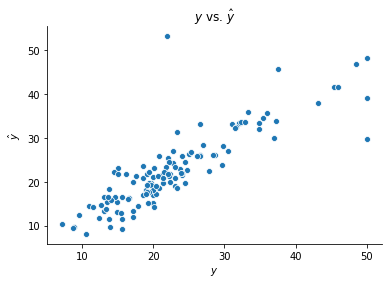

In [637]:
ffnn = FeedForwardNeuralNetwork()
ffnn.fit(X_boston_train, y_boston_train, n_hidden = 8)
y_boston_test_hat = ffnn.predict(X_boston_test)

fig, ax = plt.subplots()
sns.scatterplot(y_boston_test, y_boston_test_hat[0])
ax.set(xlabel = r'$y$', ylabel = r'$\hat{y}$', title = r'$y$ vs. $\hat{y}$')
sns.despine()

In [638]:
ffnn = FeedForwardNeuralNetwork()
ffnn.fit(X_cancer_train, y_cancer_train, n_hidden = 8,
         loss = 'log', f2 = 'sigmoid', seed = 123, lr = 1e-4)
y_cancer_test_hat = ffnn.predict(X_cancer_test)
np.mean(y_cancer_test_hat.round() == y_cancer_test)


0.9929577464788732